In [2]:
import os
import numpy as np
from PIL import Image
from scipy.io import loadmat
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Dataset Paths
datasets_train = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth")
]

datasets_test = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth")
]

In [5]:
# Parameters
IMAGE_SIZE = (300, 300)
NUM_CLASSES = 2  # Low, High crowd density classes
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Extract head count from ground truth
def get_head_count(gt_file_path):
    gt_data = loadmat(gt_file_path)
    head_count = len(gt_data["image_info"][0][0][0][0][0])
    return head_count

# Custom Dataset Class
class CrowdDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for dataset_path, ground_truth_path in dataset_paths:
            image_files = sorted(os.listdir(dataset_path), key=lambda x: int(x.split('_')[1].split('.')[0]))
            for img_file in image_files:
                img_path = os.path.join(dataset_path, img_file)
                gt_file = os.path.join(ground_truth_path, f"GT_{os.path.splitext(img_file)[0]}.mat")

                if os.path.exists(gt_file):
                    head_count = get_head_count(gt_file)
                    label = 0 if head_count <= 160 else 1  # Low Density: 0, High Density: 1

                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# Create datasets and dataloaders
train_dataset = CrowdDataset(datasets_train, transform=transform)
test_dataset = CrowdDataset(datasets_test, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
# Modified ResNet18 model for binary classification
class ResNet18Binary(nn.Module):
    def __init__(self):
        super(ResNet18Binary, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Replace the final fully connected layer for binary classification
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, NUM_CLASSES)

    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18Binary().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


In [9]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 1/10, Loss: 0.0425, Accuracy: 0.9900
Epoch 2/10, Loss: 0.0093, Accuracy: 0.9986
Epoch 3/10, Loss: 0.0024, Accuracy: 1.0000
Epoch 4/10, Loss: 0.0009, Accuracy: 1.0000
Epoch 5/10, Loss: 0.0013, Accuracy: 1.0000
Epoch 6/10, Loss: 0.0004, Accuracy: 1.0000
Epoch 7/10, Loss: 0.0003, Accuracy: 1.0000
Epoch 8/10, Loss: 0.0006, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0005, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0005, Accuracy: 1.0000
Test Accuracy: 91.37%
Classification Report:
               precision    recall  f1-score   support

 Low Density       0.88      0.96      0.92       252
High Density       0.96      0.87      0.91       246

    accuracy                           0.91       498
   macro avg       0.92      0.91      0.91       498
weighted avg       0.92      0.91      0.91       498



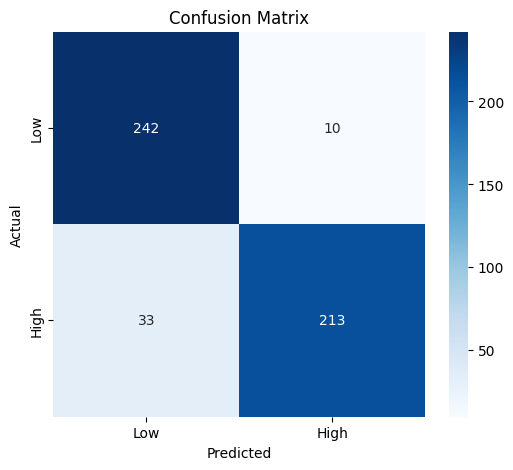

In [12]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy * 100:.2f}%')

        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Compute classification metrics
        report = classification_report(all_labels, all_preds, target_names=['Low Density', 'High Density'])

        # Print metrics
        print("Classification Report:\n", report)

        # Plot Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, EPOCHS)
evaluate_model(model, test_loader)

Epoch 1/10 - Train Loss: 0.4657, Train Acc: 80.71% | Test Loss: 1.2960, Test Acc: 81.12%
Epoch 2/10 - Train Loss: 0.2844, Train Acc: 88.29% | Test Loss: 0.8061, Test Acc: 69.28%
Epoch 3/10 - Train Loss: 0.2306, Train Acc: 91.57% | Test Loss: 0.5049, Test Acc: 83.53%
Epoch 4/10 - Train Loss: 0.2067, Train Acc: 90.57% | Test Loss: 0.3494, Test Acc: 84.14%
Epoch 5/10 - Train Loss: 0.1502, Train Acc: 94.00% | Test Loss: 2.7601, Test Acc: 61.65%
Epoch 6/10 - Train Loss: 0.1070, Train Acc: 96.43% | Test Loss: 0.7863, Test Acc: 76.31%
Epoch 7/10 - Train Loss: 0.0809, Train Acc: 96.71% | Test Loss: 0.3340, Test Acc: 87.75%
Epoch 8/10 - Train Loss: 0.0294, Train Acc: 98.86% | Test Loss: 0.5253, Test Acc: 84.34%
Epoch 9/10 - Train Loss: 0.0926, Train Acc: 96.29% | Test Loss: 2.3746, Test Acc: 72.69%
Epoch 10/10 - Train Loss: 0.0577, Train Acc: 97.57% | Test Loss: 0.2961, Test Acc: 88.76%


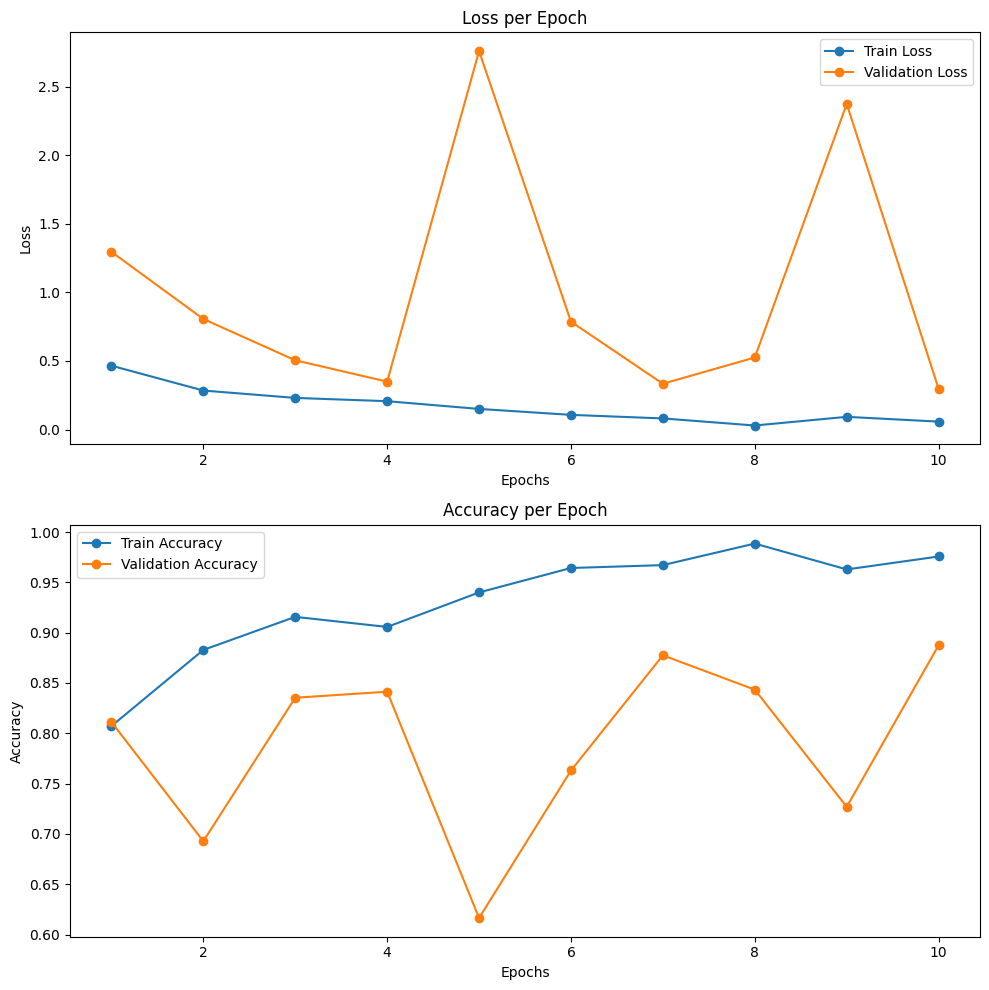

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        train_loss /= len(train_loader)

        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_accuracy = test_correct / test_total
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy*100:.2f}%')

    # Plot Training vs Validation Accuracy and Loss per epoch
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    ax[0].plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
    ax[0].plot(range(1, epochs+1), test_losses, label='Validation Loss', marker='o')
    ax[0].set_title("Loss per Epoch")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', marker='o')
    ax[1].plot(range(1, epochs+1), test_accuracies, label='Validation Accuracy', marker='o')
    ax[1].set_title("Accuracy per Epoch")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracies, test_losses, test_accuracies

# Train and evaluate the model
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, EPOCHS)
